Фарутин Вадим  
vfarut@mail.ru

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [182]:
plt.rcParams["figure.figsize"] = (15, 5)

def plot_clusters(dataset, clusters):
    colors = [color for _, color in mcolors.CSS4_COLORS.items()]
    np.random.shuffle(colors)
    colors_size = len(colors)
    marker_size = 80
    
    x = dataset
    y = np.zeros(len(dataset))
    c = [colors[cluster % colors_size] for cluster in clusters]
    
    plt.scatter(x, y, c=c, s=marker_size, edgecolors='black')
    plt.axhline(0, color='black', zorder=0)
    plt.xlabel('x')
    plt.title('Single link clustering')
    plt.show()

In [183]:
def single_link_clustering(dataset, clusters_number):
    indexed_dataset = np.array(list(enumerate(dataset)), 
                               dtype=[("index", int), ("point", float)])
    sorted_points = np.sort(indexed_dataset, order="point")
    
    distances = np.array([(point_a[0], point_b[0], point_b[1] - point_a[1])
                          for point_b, point_a in zip(sorted_points[1:], sorted_points[:-1])],
                         dtype=[("index_a", int), ("index_b", int), ("distance", float)])
    sorted_distances = np.sort(distances, order="distance")
    
    dataset_size = len(dataset)
    connected = np.repeat(False, dataset_size)
    connect_number = dataset_size - clusters_number
    for index_a, _, _ in sorted_distances[:connect_number]:
        connected[index_a] = True
    
    clusters = np.zeros(dataset_size, dtype=int)
    current_cluster = 0
    clusters[distances[0][0]] = current_cluster
    
    for index_a, index_b, _ in distances:
        if not connected[index_a]:
            current_cluster += 1
        clusters[index_b] = current_cluster
            
    return clusters

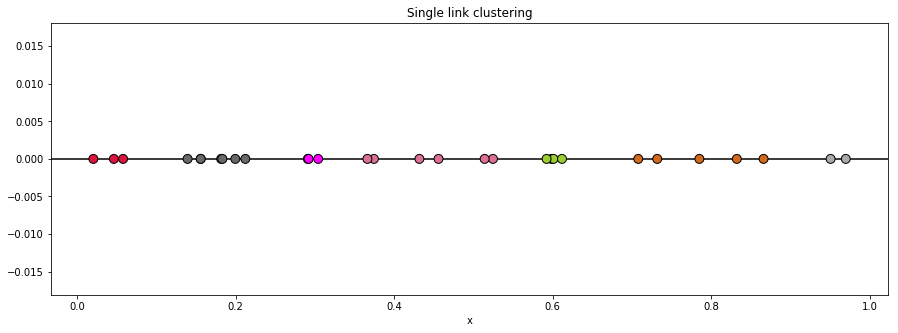

In [184]:
np.random.seed(42)
dataset = np.random.rand(30)
clusters_number = 7
clusters = single_link_clustering(dataset, clusters_number)
plot_clusters(dataset, clusters)

In [257]:
import csv
from datetime import datetime

def read_logs():
    logs = []
    
    with open('./apps_log.csv', newline='', encoding='utf8') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            if (len(row) > 1):
                time = datetime.strptime(row[1], '%d.%m.%Y %H:%M:%S').timestamp()
                logs.append(time)

    return logs

In [317]:
logs_dataset = read_logs()
logs_dataset = logs_dataset[3947:6230]
print(datetime.utcfromtimestamp(logs_dataset[-1]).strftime('%d.%m.%Y %H:%M:%S'))
print(datetime.utcfromtimestamp(logs_dataset[0]).strftime('%d.%m.%Y %H:%M:%S'))

27.03.2019 09:41:42
11.04.2019 18:28:42


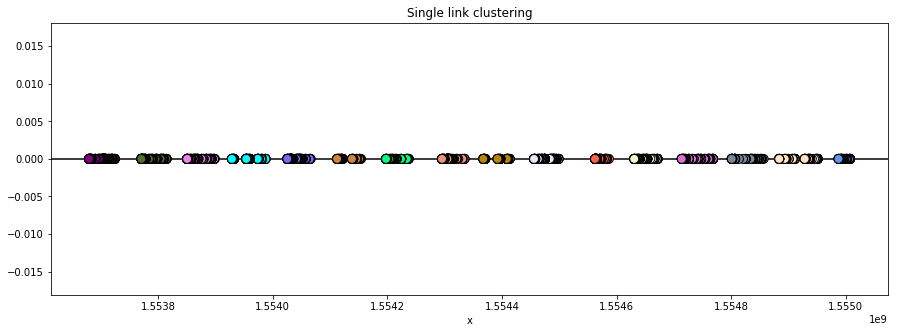

In [318]:
days_number = 16
logs_clusters = single_link_clustering(logs_dataset, days_number)
plot_clusters(logs_dataset, logs_clusters)